#Directory

In [1]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
POP_2_DIR = OUTPUT_DIR + 'pop_2_weight_oof/'
if not os.path.exists(POP_2_DIR):
    os.makedirs(POP_2_DIR)
    
POP_1_DIR = OUTPUT_DIR + 'pop_1_weight_oof/'
if not os.path.exists(POP_1_DIR):
    os.makedirs(POP_1_DIR)

# Library

In [2]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Dict, List
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
VERSION=9

In [22]:
class CFG:
    wandb = False
    debug = False
    train=True
    apex=True
    visualize=True
    stage1_pop1=True
    stage2_pop2=False
    scheduler='CosineAnnealingWarmRestarts' 
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    cosanneal_res_params={
        'T_0':20,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    print_freq=50
    num_workers = 1
    model_name = 'resnet1d_gru'
    optimizer='Adan'
    epochs = 5
    factor = 0.9
    patience = 2
    eps = 1e-6
    lr = 1e-3
    min_lr = 1e-6
    in_channels = 8
    batch_size = 64
    weight_decay = 1e-2
    batch_scheduler = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7
    seed = 2024
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    target_size = 6
    pred_cols = ['pred_seizure_vote', 'pred_lpd_vote', 'pred_gpd_vote', 'pred_lrda_vote', 'pred_grda_vote', 'pred_other_vote']
    n_fold = 3
    trn_fold = [0, 1, 2, 3, 4]
    PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"

# Utils

In [4]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(targets.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    return cv

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def denoise_filter(x):
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss



def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}    
seed_torch(seed=CFG.seed)

# Load train data

In [5]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:]
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

train_uniq = train.drop_duplicates(subset=['eeg_id'] + list(TARGETS))

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')
print(f'There are {train_uniq.shape[0]} unique eeg_id + votes in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.
There are 20183 unique eeg_id + votes in the training data.


In [6]:
eeg_df = pd.read_parquet(CFG.data_root + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

del eeg_df
_ = gc.collect()

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [7]:
%%time
all_eeg_specs = np.load('/kaggle/input/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 4.95 s, sys: 9.8 s, total: 14.7 s
Wall time: 1min 23s


# Deduplicate Train EEG Id

In [8]:
train = train[train['label_id'].isin(all_eeg_specs.keys())].copy()

y_data = train[TARGETS].values +  0.166666667 
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']
train = train.reset_index(drop=True)

# CV Scheme

In [9]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id

# Parquet to EEG Signals Numpy Processing

In [10]:
def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2
    eeg = eeg.iloc[offset:offset+10_000] 
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0

    data = np.zeros((10_000, len(eeg_features))) 
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') 
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()
        if nan_percentage < 1:
            x = np.nan_to_num(x, nan=mean)
        else:
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data

0it [00:00, ?it/s]

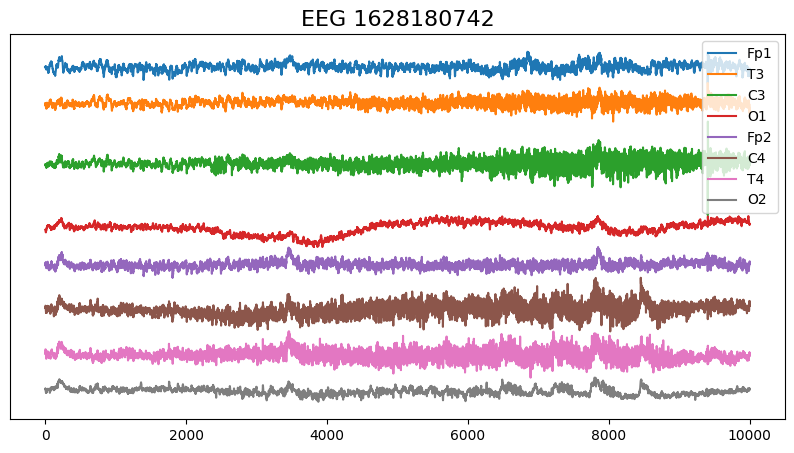

Reading 17089 eeg NumPys from disk.
CPU times: user 9.07 s, sys: 9.92 s, total: 19 s
Wall time: 1min 35s


In [11]:
%%time

CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(CFG.data_root + "*.parquet")
eeg_ids = train.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    eeg_path = CFG.data_root + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path, display=i<visualize)              
    all_eegs[eeg_id] = data
    
    if i == visualize:
        if CREATE_EEGS:
            print(f'Processing {train_df.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(eeg_ids)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs', all_eegs)
else:
    all_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

# Dataset

In [12]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class EEGDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = None
    ): 
        self.df = df
        self.config = config
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[::self.downsample,:]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        X = butter_lowpass_filter(X)
        if self.mode != 'test':
            y_prob = row[self.config.target_cols].values.astype(np.float32)
        return X, y_prob

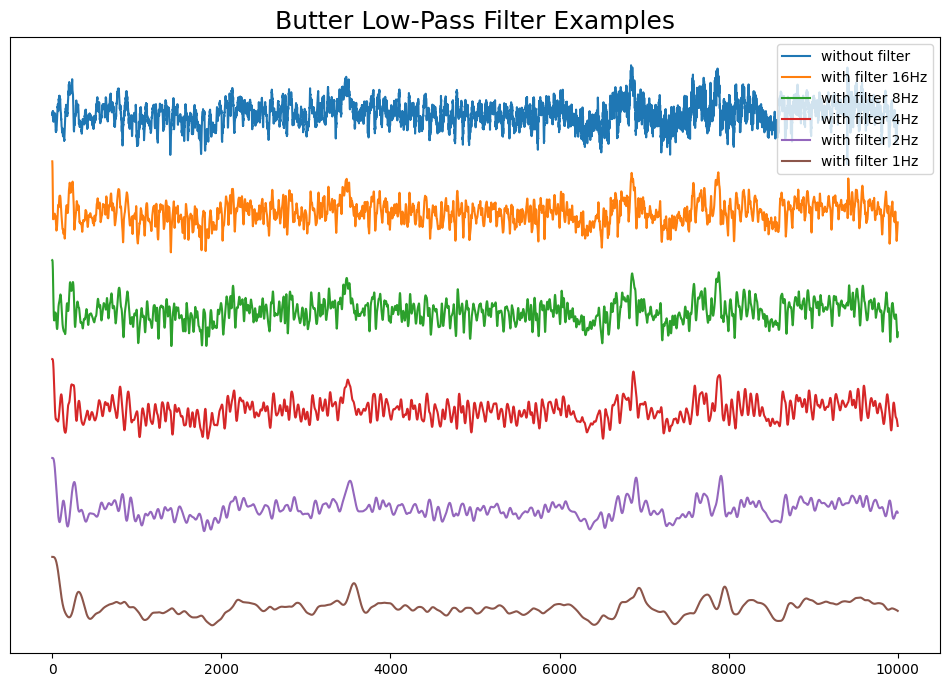

In [13]:
frequencies = [1,2,4,8,16][::-1] 
x = [all_eegs[eeg_ids[0]][:,0]] 

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

In [14]:
train_dataset = EEGDataset(train, CFG, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["eeg"], output["labels"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([10000, 8])
y shape: torch.Size([6])


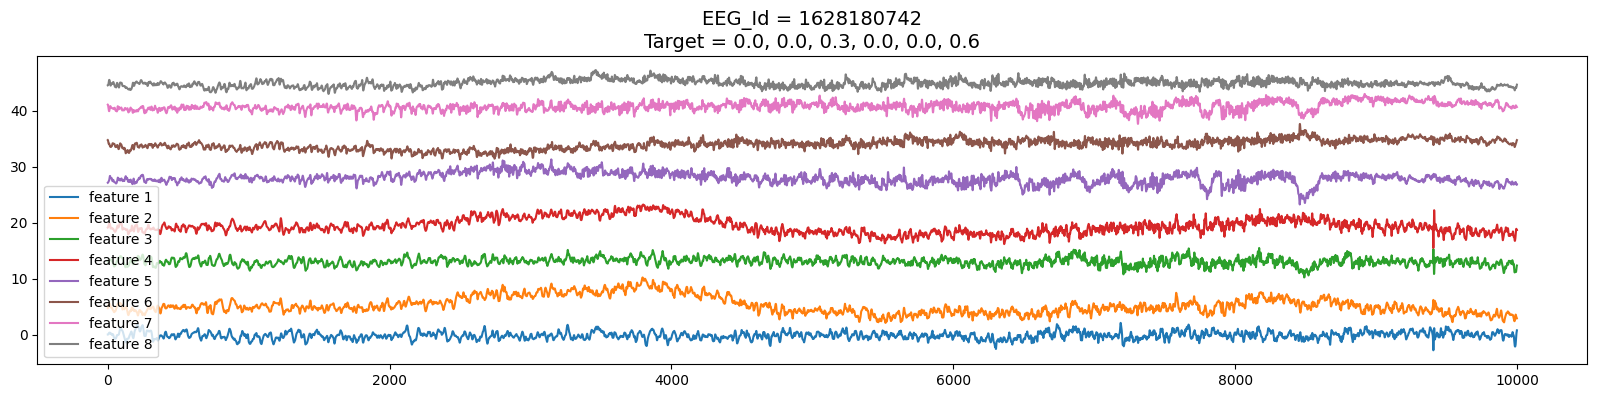

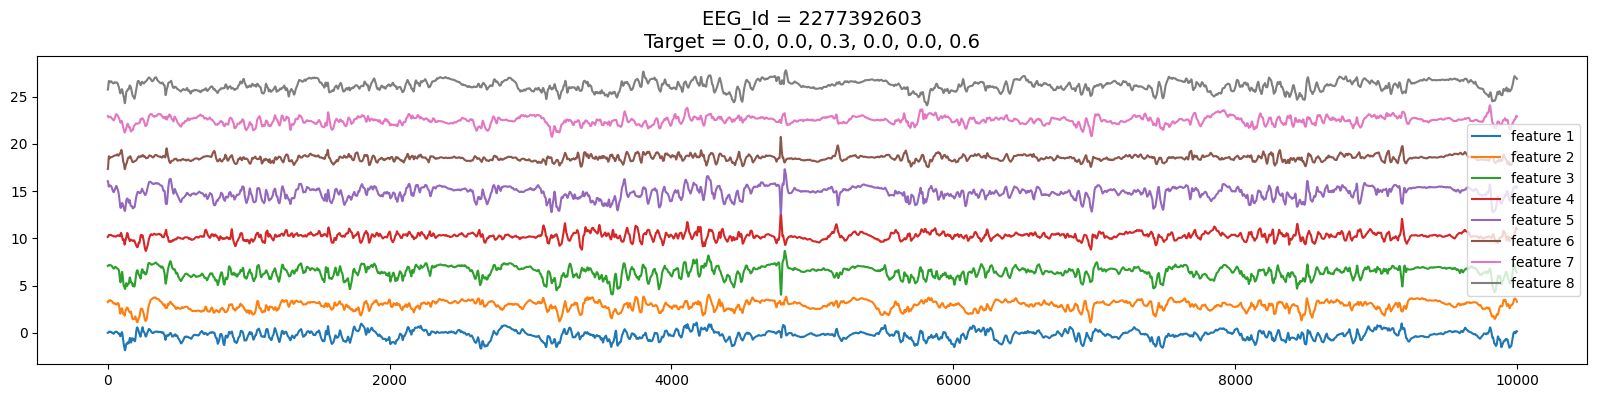

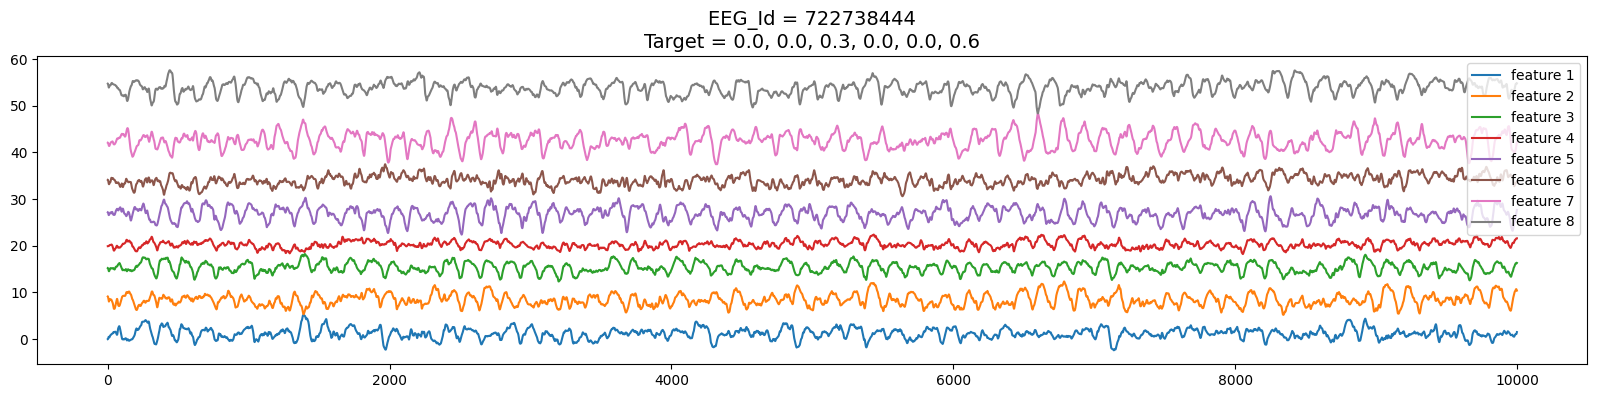

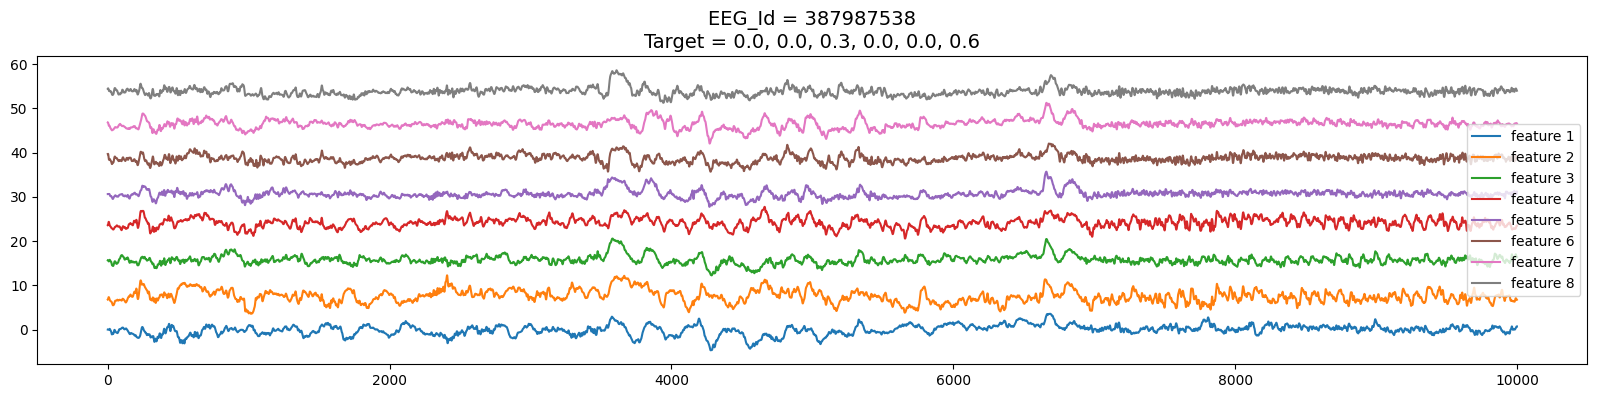

In [15]:
if CFG.visualize:
    for batch in train_loader:
        X = batch.pop("eeg")
        y = batch.pop("labels")
        for item in range(4):
            plt.figure(figsize=(20,4))
            offset = 0
            for col in range(X.shape[-1]):
                if col != 0:
                    offset -= X[item,:,col].min()
                plt.plot(range(10000), X[item,:,col]+offset,label=f'feature {col+1}')
                offset += X[item,:,col].max()
            tt = f'{y[col][0]:0.1f}'
            for t in y[col][1:]:
                tt += f', {t:0.1f}'
            plt.title(f'EEG_Id = {eeg_ids[item]}\nTarget = {tt}',size=14)
            plt.legend()
            plt.show()
        break

# Model

In [16]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.0, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):

    def __init__(self, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(in_features=424, out_features=num_classes)

    def _make_resnet_layer(self, kernel_size, stride, blocks=9, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)
    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  
        
        out = out.reshape(out.shape[0], -1)  
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  
        
        

        new_out = torch.cat([out, new_rnn_h], dim=1) 
        return new_out
    
    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)  

        return result

In [17]:
import gc
iot = torch.randn(2, 10000, 8)
model = EEGNet(kernels=[3,5,7,9], in_channels=CFG.in_channels, fixed_kernel_size=5, num_classes=CFG.target_size)
output = model(iot)
print(output.shape)

del iot, model
gc.collect()

torch.Size([2, 6])


4829

In [18]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.98, 0.92, 0.99), eps=1e-8,
                 weight_decay=0.2, max_grad_norm=0.0, no_prox=False):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm, no_prox=no_prox)
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'], device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(max_grad_norm / (global_grad_norm + group['eps']), max=1.0)
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group['betas']
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1 ** group['step']

            bias_correction2 = 1.0 - beta2 ** group['step']

            bias_correction3 = 1.0 - beta3 ** group['step']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if 'pre_grad' not in state or group['step'] == 1:
                    state['pre_grad'] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_diff']
                diff = grad - state['pre_grad']

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(group['eps'])
                update = ((exp_avg / bias_correction1 + beta2 * exp_avg_diff / bias_correction2)).div_(denom)

                if group['no_prox']:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                    p.add_(update, alpha=-group['lr'])
                else:
                    p.add_(update, alpha=-group['lr'])
                    p.data.div_(1 + group['lr'] * group['weight_decay'])

                state['pre_grad'] = copy_grad

# Helper functions

In [19]:

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):
        eegs = batch['eeg'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds= model(eegs)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
            train_losses.append(losses)
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    targets = []
    start = end = time.time()
    for step, batch in enumerate(valid_loader):
        eegs = batch['eeg'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(eegs)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            valid_losses.append(losses)
    predictions = np.concatenate(preds)
    targets = np.concatenate(targets)
    return losses.avg, predictions

# Train Loop

In [20]:

def train_loop(folds, fold, directory):
    LOGGER.info(f"========== fold: {fold} training ==========")
    if CFG.stage1_pop1:
        train_folds = folds[(folds['fold'] != fold)].reset_index(drop=True)
    else:
        train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 5)].reset_index(drop=True)
    valid_folds = folds[(folds['fold'] == fold)].reset_index(drop=True)
    valid_labels = valid_folds[ CFG.target_cols].values
    
    train_dataset = EEGDataset(train_folds, CFG, mode="train")
    valid_dataset = EEGDataset(valid_folds, CFG, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


    model = EEGNet(kernels=[3,5,7,9], in_channels=CFG.in_channels, fixed_kernel_size=5, num_classes=CFG.target_size)
    model.to(device)
    # CPMP: wrap the model to use all GPUs
    model = nn.DataParallel(model)
    
    def build_optimizer(cfg, model, device):
        lr = cfg.lr
        if cfg.optimizer == "SAM":
            base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
            optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
        elif cfg.optimizer == "Ranger21":
            optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
            num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
        elif cfg.optimizer == "SGD":
            optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
        elif cfg.optimizer == "Adam":
            optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        elif cfg.optimizer == "Lion":
            optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
        elif cfg.optimizer == "Adan":
            optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
        return optimizer_model
    
    optimizer = build_optimizer(CFG, model, device)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        elif CFG.scheduler=='OneCycleLR':
            steps_per_epoch=len(train_loader),
            scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, final_div_factor=100)
        return scheduler
    
    scheduler = get_scheduler(optimizer)

    criterion = nn.KLDivLoss(reduction="batchmean")

    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
            
        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
            if CFG.stage1_pop1:
                
                torch.save({'model': model.module.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
            else:
                
                torch.save({'model': model.module.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
    if CFG.stage1_pop1:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
                             map_location=torch.device('cpu'))['predictions']
    else:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.target_cols] = valid_labels 
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, best_score

In [23]:
if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_1_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage1: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights: {np.mean(scores)}')
        oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/252] Elapsed 0m 5s (remain 22m 3s) Loss: 0.7989(0.7989) Grad: 120741.8438  LR: 0.00099385  
Epoch: [1][50/252] Elapsed 0m 22s (remain 1m 28s) Loss: 0.6712(0.6630) Grad: 74099.9141  LR: 0.00042236  
Epoch: [1][100/252] Elapsed 0m 40s (remain 0m 59s) Loss: 0.6341(0.6419) Grad: 58418.5430  LR: 0.00099385  
Epoch: [1][150/252] Elapsed 0m 57s (remain 0m 38s) Loss: 0.5497(0.6280) Grad: 59986.9961  LR: 0.00042236  
Epoch: [1][200/252] Elapsed 1m 15s (remain 0m 19s) Loss: 0.4282(0.6104) Grad: 63414.6602  LR: 0.00099385  
Epoch: [1][250/252] Elapsed 1m 32s (remain 0m 0s) Loss: 0.5347(0.5937) Grad: 98374.1016  LR: 0.00042236  
Epoch: [1][251/252] Elapsed 1m 32s (remain 0m 0s) Loss: 0.4625(0.5932) Grad: 60948.0898  LR: 0.00034615  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 43s) Loss: 0.5757(0.5757) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.6688(0.5887) 


Epoch 1 - avg_train_loss: 0.5932  avg_val_loss: 0.5887  time: 113s
Epoch 1 - Save Best valid loss: 0.5887 Model


Epoch: [2][0/252] Elapsed 0m 0s (remain 3m 38s) Loss: 0.5356(0.5356) Grad: 64652.7773  LR: 0.00027373  
Epoch: [2][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.4702(0.4976) Grad: 83665.6953  LR: 0.00094556  
Epoch: [2][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.5412(0.4945) Grad: 99330.5391  LR: 0.00027373  
Epoch: [2][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.4176(0.4898) Grad: 96468.8516  LR: 0.00094556  
Epoch: [2][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.4507(0.4797) Grad: 82417.7578  LR: 0.00027373  
Epoch: [2][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3824(0.4706) Grad: 98476.5234  LR: 0.00094556  
Epoch: [2][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.4500(0.4706) Grad: 109304.0000  LR: 0.00090460  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 35s) Loss: 0.5184(0.5184) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.5692(0.5435) 


Epoch 2 - avg_train_loss: 0.4706  avg_val_loss: 0.5435  time: 101s
Epoch 2 - Save Best valid loss: 0.5435 Model


Epoch: [3][0/252] Elapsed 0m 0s (remain 3m 36s) Loss: 0.4089(0.4089) Grad: 110609.1406  LR: 0.00085370  
Epoch: [3][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.3981(0.4233) Grad: 90823.9844  LR: 0.00014730  
Epoch: [3][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.4294(0.4244) Grad: 105038.8672  LR: 0.00085370  
Epoch: [3][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.3732(0.4219) Grad: 99693.0625  LR: 0.00014730  
Epoch: [3][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.4172(0.4195) Grad: 123729.1016  LR: 0.00085370  
Epoch: [3][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.4062(0.4182) Grad: 95056.9844  LR: 0.00014730  
Epoch: [3][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3366(0.4179) Grad: 121289.1328  LR: 0.00009640  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 38s) Loss: 0.4917(0.4917) 
EVAL: [31/32] Elapsed 0m 18s (remain 0m 0s) Loss: 0.5365(0.5307) 


Epoch 3 - avg_train_loss: 0.4179  avg_val_loss: 0.5307  time: 100s
Epoch 3 - Save Best valid loss: 0.5307 Model


Epoch: [4][0/252] Elapsed 0m 0s (remain 3m 33s) Loss: 0.4705(0.4705) Grad: 109566.6797  LR: 0.00005544  
Epoch: [4][50/252] Elapsed 0m 16s (remain 1m 4s) Loss: 0.3878(0.4056) Grad: 107150.1250  LR: 0.00072727  
Epoch: [4][100/252] Elapsed 0m 31s (remain 0m 47s) Loss: 0.3443(0.3986) Grad: 96940.8281  LR: 0.00005544  
Epoch: [4][150/252] Elapsed 0m 46s (remain 0m 31s) Loss: 0.3945(0.3944) Grad: 97812.0000  LR: 0.00072727  
Epoch: [4][200/252] Elapsed 1m 1s (remain 0m 15s) Loss: 0.3562(0.3941) Grad: 109863.2109  LR: 0.00005544  
Epoch: [4][250/252] Elapsed 1m 17s (remain 0m 0s) Loss: 0.3252(0.3932) Grad: 124184.5234  LR: 0.00072727  
Epoch: [4][251/252] Elapsed 1m 17s (remain 0m 0s) Loss: 0.3616(0.3930) Grad: 114083.1094  LR: 0.00065485  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 37s) Loss: 0.4860(0.4860) 
EVAL: [31/32] Elapsed 0m 18s (remain 0m 0s) Loss: 0.5416(0.5409) 


Epoch 4 - avg_train_loss: 0.3930  avg_val_loss: 0.5409  time: 97s


Epoch: [5][0/252] Elapsed 0m 0s (remain 3m 37s) Loss: 0.3613(0.3613) Grad: 130543.8438  LR: 0.00057864  
Epoch: [5][50/252] Elapsed 0m 17s (remain 1m 7s) Loss: 0.4510(0.3811) Grad: 131576.2188  LR: 0.00000715  
Epoch: [5][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.3098(0.3802) Grad: 104025.9141  LR: 0.00057864  
Epoch: [5][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.3655(0.3776) Grad: 122457.0391  LR: 0.00000715  
Epoch: [5][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.4426(0.3774) Grad: 119459.6641  LR: 0.00057864  
Epoch: [5][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3720(0.3756) Grad: 121221.3438  LR: 0.00000715  
Epoch: [5][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3880(0.3757) Grad: 119550.2422  LR: 0.00100000  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 37s) Loss: 0.4745(0.4745) 
EVAL: [31/32] Elapsed 0m 18s (remain 0m 0s) Loss: 0.5252(0.5017) 


Epoch 5 - avg_train_loss: 0.3757  avg_val_loss: 0.5017  time: 100s
Epoch 5 - Save Best valid loss: 0.5017 Model
========== fold: 0 result ==========
Score with best loss weights stage1: 0.5016943276268083
========== fold: 1 training ==========


Epoch: [1][0/252] Elapsed 0m 0s (remain 3m 46s) Loss: 0.7863(0.7863) Grad: 99467.8516  LR: 0.00099385  
Epoch: [1][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.5922(0.6600) Grad: 49805.9922  LR: 0.00042236  
Epoch: [1][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.5888(0.6413) Grad: 49677.4883  LR: 0.00099385  
Epoch: [1][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.5745(0.6215) Grad: 60740.0039  LR: 0.00042236  
Epoch: [1][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.5458(0.6043) Grad: 68243.6484  LR: 0.00099385  
Epoch: [1][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.5789(0.5877) Grad: 96609.0156  LR: 0.00042236  
Epoch: [1][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.4279(0.5871) Grad: 61474.2578  LR: 0.00034615  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 35s) Loss: 0.4844(0.4844) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.5298(0.5305) 


Epoch 1 - avg_train_loss: 0.5871  avg_val_loss: 0.5305  time: 101s
Epoch 1 - Save Best valid loss: 0.5305 Model


Epoch: [2][0/252] Elapsed 0m 0s (remain 3m 37s) Loss: 0.4990(0.4990) Grad: 67879.4375  LR: 0.00027373  
Epoch: [2][50/252] Elapsed 0m 17s (remain 1m 8s) Loss: 0.4816(0.4869) Grad: 77287.0078  LR: 0.00094556  
Epoch: [2][100/252] Elapsed 0m 32s (remain 0m 49s) Loss: 0.4985(0.4813) Grad: 103691.1875  LR: 0.00027373  
Epoch: [2][150/252] Elapsed 0m 47s (remain 0m 32s) Loss: 0.4791(0.4704) Grad: 77009.2344  LR: 0.00094556  
Epoch: [2][200/252] Elapsed 1m 3s (remain 0m 16s) Loss: 0.4459(0.4622) Grad: 80312.6953  LR: 0.00027373  
Epoch: [2][250/252] Elapsed 1m 18s (remain 0m 0s) Loss: 0.4662(0.4585) Grad: 96901.4609  LR: 0.00094556  
Epoch: [2][251/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.3477(0.4580) Grad: 77088.5391  LR: 0.00090460  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 35s) Loss: 0.4265(0.4265) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4659(0.4858) 


Epoch 2 - avg_train_loss: 0.4580  avg_val_loss: 0.4858  time: 99s
Epoch 2 - Save Best valid loss: 0.4858 Model


Epoch: [3][0/252] Elapsed 0m 0s (remain 3m 35s) Loss: 0.4118(0.4118) Grad: 105435.6250  LR: 0.00085370  
Epoch: [3][50/252] Elapsed 0m 17s (remain 1m 7s) Loss: 0.4810(0.4199) Grad: 96995.8203  LR: 0.00014730  
Epoch: [3][100/252] Elapsed 0m 33s (remain 0m 50s) Loss: 0.3940(0.4159) Grad: 75520.6328  LR: 0.00085370  
Epoch: [3][150/252] Elapsed 0m 49s (remain 0m 32s) Loss: 0.3712(0.4205) Grad: 98128.1016  LR: 0.00014730  
Epoch: [3][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.4418(0.4179) Grad: 114726.6172  LR: 0.00085370  
Epoch: [3][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.4244(0.4157) Grad: 121891.4219  LR: 0.00014730  
Epoch: [3][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.4032(0.4157) Grad: 100742.6250  LR: 0.00009640  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 39s) Loss: 0.4572(0.4572) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4762(0.4708) 


Epoch 3 - avg_train_loss: 0.4157  avg_val_loss: 0.4708  time: 101s
Epoch 3 - Save Best valid loss: 0.4708 Model


Epoch: [4][0/252] Elapsed 0m 0s (remain 3m 37s) Loss: 0.4032(0.4032) Grad: 128397.4453  LR: 0.00005544  
Epoch: [4][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.4233(0.3851) Grad: 119813.3359  LR: 0.00072727  
Epoch: [4][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.4403(0.3904) Grad: 119396.9219  LR: 0.00005544  
Epoch: [4][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.3691(0.3880) Grad: 122498.8828  LR: 0.00072727  
Epoch: [4][200/252] Elapsed 1m 3s (remain 0m 16s) Loss: 0.3544(0.3871) Grad: 146361.3281  LR: 0.00005544  
Epoch: [4][250/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.4011(0.3874) Grad: 133865.3438  LR: 0.00072727  
Epoch: [4][251/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.3257(0.3871) Grad: 114931.1641  LR: 0.00065485  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 37s) Loss: 0.4352(0.4352) 
EVAL: [31/32] Elapsed 0m 18s (remain 0m 0s) Loss: 0.4747(0.4593) 


Epoch 4 - avg_train_loss: 0.3871  avg_val_loss: 0.4593  time: 100s
Epoch 4 - Save Best valid loss: 0.4593 Model


Epoch: [5][0/252] Elapsed 0m 0s (remain 3m 38s) Loss: 0.4089(0.4089) Grad: 112408.8516  LR: 0.00057864  
Epoch: [5][50/252] Elapsed 0m 17s (remain 1m 10s) Loss: 0.3318(0.3768) Grad: 115876.8281  LR: 0.00000715  
Epoch: [5][100/252] Elapsed 0m 33s (remain 0m 49s) Loss: 0.3824(0.3732) Grad: 123756.2891  LR: 0.00057864  
Epoch: [5][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.3826(0.3693) Grad: 125062.0156  LR: 0.00000715  
Epoch: [5][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.3180(0.3701) Grad: 99732.1562  LR: 0.00057864  
Epoch: [5][250/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.4385(0.3710) Grad: 128747.6016  LR: 0.00000715  
Epoch: [5][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3292(0.3708) Grad: 134990.0781  LR: 0.00100000  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 38s) Loss: 0.4061(0.4061) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4349(0.4345) 


Epoch 5 - avg_train_loss: 0.3708  avg_val_loss: 0.4345  time: 101s
Epoch 5 - Save Best valid loss: 0.4345 Model
========== fold: 1 result ==========
Score with best loss weights stage1: 0.4344697805850081
========== fold: 2 training ==========


Epoch: [1][0/252] Elapsed 0m 0s (remain 3m 42s) Loss: 0.7929(0.7929) Grad: 125019.6875  LR: 0.00099385  
Epoch: [1][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.6543(0.6721) Grad: 44204.1484  LR: 0.00042236  
Epoch: [1][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.5907(0.6436) Grad: 52021.0859  LR: 0.00099385  
Epoch: [1][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.6201(0.6279) Grad: 51982.0859  LR: 0.00042236  
Epoch: [1][200/252] Elapsed 1m 3s (remain 0m 16s) Loss: 0.5078(0.6126) Grad: 56907.3633  LR: 0.00099385  
Epoch: [1][250/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.5349(0.5996) Grad: 55700.7656  LR: 0.00042236  
Epoch: [1][251/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.5616(0.5995) Grad: 74818.7969  LR: 0.00034615  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 35s) Loss: 0.6494(0.6494) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.5211(0.5642) 


Epoch 1 - avg_train_loss: 0.5995  avg_val_loss: 0.5642  time: 101s
Epoch 1 - Save Best valid loss: 0.5642 Model


Epoch: [2][0/252] Elapsed 0m 0s (remain 3m 39s) Loss: 0.5856(0.5856) Grad: 60349.7734  LR: 0.00027373  
Epoch: [2][50/252] Elapsed 0m 16s (remain 1m 5s) Loss: 0.5520(0.5157) Grad: 77900.4531  LR: 0.00094556  
Epoch: [2][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.5027(0.5006) Grad: 101629.1250  LR: 0.00027373  
Epoch: [2][150/252] Elapsed 0m 47s (remain 0m 31s) Loss: 0.5143(0.4878) Grad: 116022.0625  LR: 0.00094556  
Epoch: [2][200/252] Elapsed 1m 3s (remain 0m 16s) Loss: 0.4785(0.4766) Grad: 98050.6172  LR: 0.00027373  
Epoch: [2][250/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.4604(0.4699) Grad: 87638.3984  LR: 0.00094556  
Epoch: [2][251/252] Elapsed 1m 19s (remain 0m 0s) Loss: 0.3911(0.4696) Grad: 82862.2031  LR: 0.00090460  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 38s) Loss: 0.6268(0.6268) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.5168(0.5123) 


Epoch 2 - avg_train_loss: 0.4696  avg_val_loss: 0.5123  time: 100s
Epoch 2 - Save Best valid loss: 0.5123 Model


Epoch: [3][0/252] Elapsed 0m 0s (remain 3m 42s) Loss: 0.4628(0.4628) Grad: 116510.3516  LR: 0.00085370  
Epoch: [3][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.3968(0.4221) Grad: 96598.1719  LR: 0.00014730  
Epoch: [3][100/252] Elapsed 0m 32s (remain 0m 48s) Loss: 0.3383(0.4288) Grad: 82485.5938  LR: 0.00085370  
Epoch: [3][150/252] Elapsed 0m 48s (remain 0m 32s) Loss: 0.3939(0.4203) Grad: 92400.6406  LR: 0.00014730  
Epoch: [3][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.4177(0.4168) Grad: 104699.6562  LR: 0.00085370  
Epoch: [3][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3971(0.4139) Grad: 84010.1250  LR: 0.00014730  
Epoch: [3][251/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3735(0.4137) Grad: 115927.0625  LR: 0.00009640  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 36s) Loss: 0.6277(0.6277) 
EVAL: [31/32] Elapsed 0m 18s (remain 0m 0s) Loss: 0.5014(0.5174) 


Epoch 3 - avg_train_loss: 0.4137  avg_val_loss: 0.5174  time: 100s


Epoch: [4][0/252] Elapsed 0m 0s (remain 3m 34s) Loss: 0.4122(0.4122) Grad: 122652.0938  LR: 0.00005544  
Epoch: [4][50/252] Elapsed 0m 17s (remain 1m 7s) Loss: 0.4392(0.3924) Grad: 108548.3984  LR: 0.00072727  
Epoch: [4][100/252] Elapsed 0m 33s (remain 0m 49s) Loss: 0.4666(0.3890) Grad: 133806.3906  LR: 0.00005544  
Epoch: [4][150/252] Elapsed 0m 49s (remain 0m 33s) Loss: 0.4253(0.3911) Grad: 104645.0781  LR: 0.00072727  
Epoch: [4][200/252] Elapsed 1m 5s (remain 0m 16s) Loss: 0.3884(0.3889) Grad: 150619.2656  LR: 0.00005544  
Epoch: [4][250/252] Elapsed 1m 20s (remain 0m 0s) Loss: 0.3738(0.3884) Grad: 88071.0391  LR: 0.00072727  
Epoch: [4][251/252] Elapsed 1m 21s (remain 0m 0s) Loss: 0.3658(0.3883) Grad: 92132.9375  LR: 0.00065485  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 36s) Loss: 0.5449(0.5449) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4765(0.4922) 


Epoch 4 - avg_train_loss: 0.3883  avg_val_loss: 0.4922  time: 102s
Epoch 4 - Save Best valid loss: 0.4922 Model


Epoch: [5][0/252] Elapsed 0m 0s (remain 3m 38s) Loss: 0.3874(0.3874) Grad: 108919.4531  LR: 0.00057864  
Epoch: [5][50/252] Elapsed 0m 16s (remain 1m 6s) Loss: 0.4028(0.3787) Grad: 126511.1172  LR: 0.00000715  
Epoch: [5][100/252] Elapsed 0m 32s (remain 0m 49s) Loss: 0.4384(0.3761) Grad: 114092.7031  LR: 0.00057864  
Epoch: [5][150/252] Elapsed 0m 49s (remain 0m 32s) Loss: 0.3559(0.3729) Grad: 120674.5547  LR: 0.00000715  
Epoch: [5][200/252] Elapsed 1m 4s (remain 0m 16s) Loss: 0.3352(0.3700) Grad: 103879.2422  LR: 0.00057864  
Epoch: [5][250/252] Elapsed 1m 21s (remain 0m 0s) Loss: 0.3571(0.3691) Grad: 137556.0156  LR: 0.00000715  
Epoch: [5][251/252] Elapsed 1m 21s (remain 0m 0s) Loss: 0.4130(0.3693) Grad: 120658.7266  LR: 0.00100000  
EVAL: [0/32] Elapsed 0m 1s (remain 0m 42s) Loss: 0.5894(0.5894) 
EVAL: [31/32] Elapsed 0m 19s (remain 0m 0s) Loss: 0.4813(0.4878) 


Epoch 5 - avg_train_loss: 0.3693  avg_val_loss: 0.4878  time: 101s
Epoch 5 - Save Best valid loss: 0.4878 Model
========== fold: 2 result ==========
Score with best loss weights stage1: 0.48780881993127456
========== CV ==========
Score with best loss weights: 0.4746576427143636


In [24]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = CFG.target_cols
gt = oof_df[["eeg_id"] + CFG.target_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

preds = oof_df[["eeg_id"] + CFG.pred_cols]
preds.columns = ["eeg_id"] + CFG.target_cols
preds.sort_values(by="eeg_id", inplace=True)
preds.reset_index(inplace=True, drop=True)

y_trues = gt[CFG.target_cols]
y_preds = preds[CFG.target_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Stage2 Score with resnet1D_gru Raw EEG =',cv)

CV Stage2 Score with resnet1D_gru Raw EEG = 0.47465764291881174


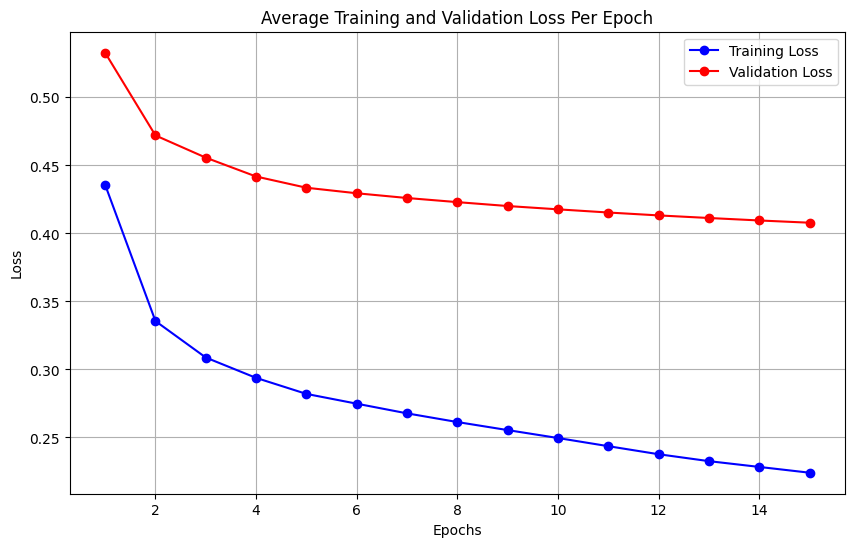

In [27]:
# Number of epochs
num_epochs = 15
# Average losses per epoch 
average_train_losses = [sum(train_losses[i*6:(i+1)*6])/6 for i in range(num_epochs)]
average_val_losses = [sum(val_losses[i*6:(i+1)*6])/6 for i in range(num_epochs)]

plt.figure(figsize=(10, 6))
plt.plot(epochs, average_train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, average_val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Per Epoch')
plt.legend()
plt.grid(True)
plt.show()